# **Dynamic Model for Covid-19 Disease**

Until now, our studies only dealt with unflexible mathematical epidemiological models based on the SIRD model, considering every specific parameters as constant. \\
This Notebook marks a step into our researches, as it is a proposition to build a dynamical model, evolving this time regarding the present state of the system.

# **Libraries**

## **General packages**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.linalg as npl
from numpy.linalg import matrix_rank

In [2]:
!pip install xlrd
# Graphics
!pip install -U plotly
# Excel spreadsheet organization
!pip install nltk
# Exporting pictures with better resolutions
!pip install -U kaleido

!add-apt-repository -y ppa:cran/poppler
!apt-get update
!apt-get install -y libpoppler-cpp-dev
!apt-get install poppler-utils

     |████████████████████████████████| 20.6MB 1.3MB/s 
  Found existing installation: plotly 4.4.1
    Uninstalling plotly-4.4.1:
      Successfully uninstalled plotly-4.4.1
     |████████████████████████████████| 79.9MB 64kB/s 
Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:6 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Rele

In [3]:
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Images directory
import os
if not os.path.exists("images"):
    os.mkdir("images")


## **Control**

In [4]:
# Control library and dynamic system

!git clone https://github.com/python-control/python-control.git

!pip install slycot
!pip install control

Cloning into 'python-control'...
remote: Enumerating objects: 7706, done.
remote: Counting objects: 100% (585/585), done.
remote: Compressing objects: 100% (219/219), done.
remote: Total 7706 (delta 409), reused 498 (delta 366), pack-reused 7121
Receiving objects: 100% (7706/7706), 8.52 MiB | 24.57 MiB/s, done.
Resolving deltas: 100% (5719/5719), done.
     |████████████████████████████████| 1.6MB 4.1MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for slycot: filename=slycot-0.4.0-cp37-cp37m-linux_x86_64.whl size=1417855 sha256=703e7e7d918b3c63361da5a2924701fa16ba38052dab15a2cb88a7028abfb611
  Stored in directory: /root/.cache/pip/wheels/a2/46/56/f82cbb2fd06556f4f3952a2eb2396e8fd29264fffecbaad3cf
Successfully built slycot
     |████████████████████████████████| 348kB 4.0MB/s 
  Created wheel for control: filename=control-0.9.0-py2.py3-none-any.whl size=344929 sha256=37b56acc590a30ba2fe90

In [5]:
import control
from control import impulse_response, step_response

# **Utilitary Functions**

In [16]:
def graphics_plot(t, y, y_title, title):
  # Plotting the results

  fig = go.Figure()

  for i in range(len(y)):
    if i<4:
      fig.add_trace(go.Scatter(
      name=y_title[i],
      x=t,
      y=y[i],
      mode='lines',
      marker_symbol='circle',
      line=dict(width=3, dash="dash")
      ))
    else:
      fig.add_trace(go.Scatter(
      name=y_title[i],
      x=t,
      y=y[i],
      mode='lines',
      marker_symbol='circle',
      line=dict(width=3, dash="solid")
      ))
  
  fig.update_layout(
      template='xgridoff',
      xaxis=dict(showgrid=False),
      xaxis_title='Date',
      yaxis_title='Individuals',
      legend=dict(
        orientation='h',
        yanchor='bottom',
        y=1.01,
        xanchor='right',
        x=0.95
        ),
      title_text=title)

  fig.show()

# **Data**

In [7]:
  # Loading data - wcota
data_path = 'https://raw.githubusercontent.com/wcota/covid19br/master/cases-brazil-states.csv'
df = pd.read_csv(data_path, delimiter=",") 

  # Dataframe for the specific State Acre
df_state = df[df.state == 'AC'].reset_index()

  # Creating new recovered column
df_state["newRecovered"] = df_state["recovered"].diff()
df_state.newRecovered.fillna(0, inplace=True)
df_state.recovered.fillna(0, inplace=True)

  # Creating active cases column (Infected)
active_infected = [df_state["totalCases"].iloc[0]]
for nc, nr in zip(df_state["newCases"].iloc[1:], 
                  df_state["newRecovered"].iloc[1:]):
    active_infected.append(active_infected[-1] + nc - nr)
df_state["activeCases"] = active_infected

df_state = df_state[['date','activeCases','recovered','deaths']].iloc[:200]

df_state.tail()

,date,activeCases,recovered,deaths
195,2020-09-28,3010.0,24885.0,657
196,2020-09-29,2999.0,25041.0,657
197,2020-09-30,3191.0,25041.0,659
198,2020-10-01,1714.0,26705.0,661
199,2020-10-02,1860.0,26705.0,664


In [8]:
#  Real data for the model analysis

Infected = np.array(df_state['activeCases']/100)
Recovered = np.array(df_state['recovered']/100)
Deceased = np.array(df_state['deaths']/100)
N = Infected[-1]+Recovered[-1]+Deceased[-1]
Susceptible = np.array(N - Infected - Recovered)
Date = np.array(df_state['date'])

In [9]:
graphics_plot(Date, [Susceptible,Infected,Recovered,Deceased], ['Susceptible','Infected', 'Recovered', 'Deceased'], 'Covid-19 - ACRE State')

# **Dynamic Model**

**Susceptible**

$$ \begin{split}
   \frac{dS(t)}{dt} & = \frac{-\beta I(t) S(t)}{(P)}
   \end{split} $$
**Infected**

\begin{split}
\frac{dI(t)}{dt} & = \frac{\beta I(t) S(t)}{(P)} -\gamma I(t) -\mu I(t)
\end{split}
**Recovered**

\begin{split}
\frac{dR(t)}{dt} & = \gamma I(t)
\end{split}
**Deceased**

\begin{split}
\frac{dD(t)}{dt} & = \mu I(t)
\end{split}

In [10]:
#  Non Linear Model

def dynamicmodel(t, x, u, parameters):
  """ Creation of the non linear model phenomenon
    t: timeline
    x: initial state vector
    u: input
    parameters: model's parameters """

  # Initial Parameters

  beta = parameters.get('beta', 2.42477206e-04) #tuned found parameters
  gamma = parameters.get('gamma', 2.59729704e-02)
  mu = parameters.get('mu', 6.49310855e-03)
  u_0 = u

  # Initial Values of SIRD - x_o =[xo1 xo2].T
  S = x[0];
  I = x[1];
  R = x[2];
  D = x[3];

  # System's entry - Add content in the system - Never remove
  u = u_0 if u > 0 else 0 

  # Formalize equations
  dS = -beta*I*S
  dI = beta*I*S - gamma*I - mu*I
  dR = gamma*I
  dD = mu*I

  return [dS,dI,dR,dD]

In [11]:
#  Subsystem Creation - Bloc's creation

io_dynamicmodel = control.NonlinearIOSystem(
    dynamicmodel, None, inputs=('u'), outputs=('S','I','R','D'),
    states=('S','I','R','D'), name='SIRD')

In [12]:
#  Determination of the equilibrium point

x0 = [Susceptible[0],Infected[0],Recovered[0],Deceased[0]]
equilibrium = control.find_eqpt(io_dynamicmodel,x0,0)
equilibrium

(array([174.0276842 ,   0.        ,   0.74014845,   0.21865564]), array([0.]))

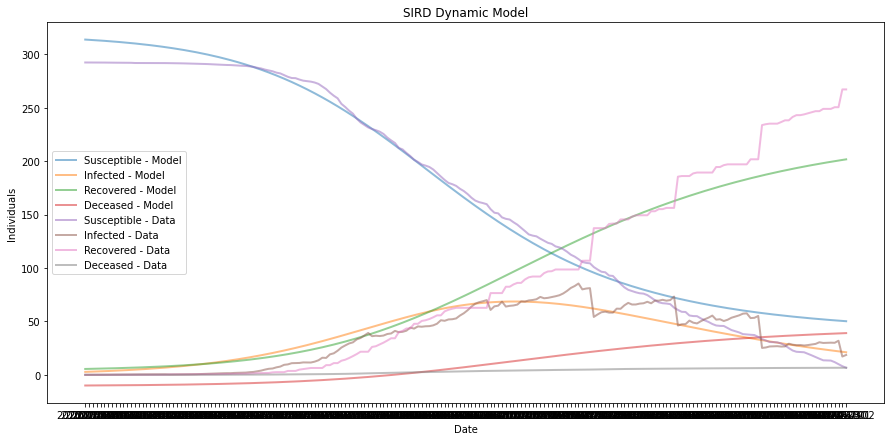

In [38]:
# Simulation

x0 = [3.13691306e+02, 2.76203192e+00, 5.51029952e+00, -9.97377960e+00] #Tuned parameters
#x0 = [ 1.46211566e+02, 2.5, -4.56702770e+02, -5.58519759e+01] #Equilibrium values
T  = np.linspace(0,len(Date)-1,len(Date))  #time vector

# Calculation

t, y = control.input_output_response(io_dynamicmodel, T, 0, x0)

plt.figure(figsize=(15,7))
plt.plot(t,y[0], alpha=0.5, lw=2, label='Susceptible - Model') 
plt.plot(t,y[1], alpha=0.5, lw=2, label='Infected - Model')
plt.plot(t,y[2], alpha=0.5, lw=2, label='Recovered - Model')
plt.plot(t,y[3], alpha=0.5, lw=2, label='Deceased - Model')
plt.plot(Date,Susceptible, alpha=0.5, lw=2, label='Susceptible - Data')
plt.plot(Date,Infected, alpha=0.5, lw=2, label='Infected - Data')
plt.plot(Date,Recovered, alpha=0.5, lw=2, label='Recovered - Data')
plt.plot(Date,Deceased, alpha=0.5, lw=2, label='Deceased - Data')
plt.legend()
plt.title('SIRD Dynamic Model')
plt.xlabel('Date')
plt.ylabel('Individuals')

plt.show()

**Observations:** With the given equilibrium values, we do not get relevant simulation of the model.
To fit the model perfectly, we need to tune and find the best parameters. 

In [17]:
graphics_plot(Date, [y[0],y[1],y[2],y[3],Susceptible,Infected,Recovered,Deceased], ['Susceptible - model','Infected - model', 'Recovered - model', 'Deceased - model','Susceptible - data','Infected - data', 'Recovered - data', 'Deceased - data'], 'Covid-19 Dynamic Modelization - ACRE State')

# **Control Project**

## **Formulation of the problem**

The vector of state dynamics functions represented by eq. 
(1) is given in more details as:
\begin{equation}
\left\{ {\begin{array}{l}
 \dot {x}_1 (t)=f_1 \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right); \\ 
 \dot {x}_2 (t)=f_2 \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right); \\ 
 \vdots \\ 
 \dot {x}_n (t)=f_n \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right). \\ 
 \end{array}} \right.
\end{equation}

The output vector represented by eq. (2) is given in more details as:
\begin{equation}
\left\{ {\begin{array}{l}
 y_1 (t)=g_1 \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right); \\ 
 y_2 (t)=g_2 \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right); \\ 
 \vdots \\ 
 y_p (t)=g_p \left( {{\rm {\bf x}}(t),{\rm {\bf u}}(t)} \right). \\ 
 \end{array}} \right.
\end{equation}

Given the nominal operating conditions, expansion of the vector of functions $\textbf{f}(\textbf{x},\textbf{u})$ around $\textbf{x}_{0}(t)$ and $\textbf{u}_{0}(t)$

$\quad \Rightarrow $ Each equation of the dynamic system: $\dot {x}_i (t)=f_i ({\rm {\bf x}}(t),{\rm {\bf u}}(t))$, for $i = 1 \dots n$, now becomes:


\begin{equation}
\begin{array}{l}
 \frac{d}{dt}\left( {x_{0,i} (t)+\delta x_i (t)} \right)=f_i \left( {{\rm 
{\bf x}}_{\rm {\bf 0}} (t)+\delta {\rm {\bf x}}(t),{\rm {\bf u}}_{\rm {\bf 
0}} (t)+\delta {\rm {\bf u}}(t)} \right)= \\ 
 \mbox{ }f_i \left( {{\rm {\bf x}}_{\rm {\bf 0}} (t),{\rm {\bf u}}_{\rm {\bf 
0}} (t)} \right)+\left( {\frac{\partial f_i }{\partial {\rm {\bf x}}}} 
\right)_{\rm {\bf 0}} \delta {\rm {\bf x}}(t)+\left( {\frac{\partial f_i 
}{\partial {\rm {\bf u}}}} \right)_{\rm {\bf 0}} \delta {\rm {\bf 
u}}(t)+T.O.S. \\ 
 \end{array}
\end{equation}

For all $n$ equations in the system, you have:
\begin{equation}
\frac{d}{dt}\delta {\rm {\bf x}}(t)=\left[ {\begin{array}{l}
 \left( {\frac{\partial f_1 }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \left( {\frac{\partial f_2 }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \vdots \\ 
 \left( {\frac{\partial f_n }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \end{array}} \right]\delta {\rm {\bf x}}(t)+\left[ {\begin{array}{l}
 \left( {\frac{\partial f_1 }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \left( {\frac{\partial f_2 }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \vdots \\ 
 \left( {\frac{\partial f_n }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \end{array}} \right]\delta {\rm {\bf u}}(t),
\end{equation}
or the more reduced form,
\begin{equation}
\frac{d}{dt}\delta {\rm {\bf x}}(t)={\rm {\bf A}}(t)\delta {\rm {\bf 
x}}(t)+{\rm {\bf B}}(t)\delta {\rm {\bf u}}(t).
\end{equation}

\begin{equation}
{\rm {\bf A}}(t)=\left[ {{\begin{array}{*{20}c}
 {\left( {\frac{\partial f_1 }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_1 }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_1 }{\partial x_n }} \right)_0 } \hfill \\
 {\left( {\frac{\partial f_2 }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_2 }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_2 }{\partial x_n }} \right)_0 } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {\left( {\frac{\partial f_n }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_n }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_n }{\partial x_n }} \right)_0 } \hfill \\
\end{array} }} \right]_{(nxn)} 
\end{equation}
\begin{equation}
{\rm {\bf B}}(t)=\left[ {{\begin{array}{*{20}c}
 {\left( {\frac{\partial f_1 }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_1 }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_1 }{\partial u_m }} \right)_0 } \hfill \\
 {\left( {\frac{\partial f_2 }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_2 }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_2 }{\partial u_m }} \right)_0 } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {\left( {\frac{\partial f_n }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial f_n }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial f_n }{\partial u_m }} \right)_0 } \hfill \\
\end{array} }} \right]_{(nxm)} 
\end{equation}

For all $p$ equations in the output system, you have:
\begin{equation}
\delta {\rm {\bf y}}(t)=\left[ {\begin{array}{l}
 \left( {\frac{\partial g_1 }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \left( {\frac{\partial g_2 }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \vdots \\ 
 \left( {\frac{\partial g_p }{\partial {\rm {\bf x}}}} \right)_0 \\ 
 \end{array}} \right]\delta {\rm {\bf x}}(t)+\left[ {\begin{array}{l}
 \left( {\frac{\partial g_1 }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \left( {\frac{\partial g_2 }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \vdots \\ 
 \left( {\frac{\partial g_p }{\partial {\rm {\bf u}}}} \right)_0 \\ 
 \end{array}} \right]\delta {\rm {\bf u}}(t),
\end{equation}
or the reduced form,
\begin{equation}
\delta {\rm {\bf y}}(t)={\rm {\bf C}}(t)\delta {\rm {\bf x}}(t)+{\rm {\bf 
D}}(t)\delta {\rm {\bf u}}(t).
\end{equation}

where $\textbf{C}(t)$ and $\textbf{D}(t)$ are the given matrices for:
\begin{equation}
{\rm {\bf C}}(t)=\left[ {{\begin{array}{*{20}c}
 {\left( {\frac{\partial g_1 }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_1 }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_1 }{\partial x_n }} \right)_0 } \hfill \\
 {\left( {\frac{\partial g_2 }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_2 }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_2 }{\partial x_n }} \right)_0 } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {\left( {\frac{\partial g_p }{\partial x_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_p }{\partial x_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_p }{\partial x_n }} \right)_0 } \hfill \\
\end{array} }} \right]_{(pxn)} 
\end{equation}
\begin{equation}
{\rm {\bf D}}(t)=\left[ {{\begin{array}{*{20}c}
 {\left( {\frac{\partial g_1 }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_1 }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_1 }{\partial u_m }} \right)_0 } \hfill \\
 {\left( {\frac{\partial g_2 }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_2 }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_2 }{\partial u_m }} \right)_0 } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {\left( {\frac{\partial g_p }{\partial u_1 }} \right)_0 } \hfill & {\left( 
{\frac{\partial g_p }{\partial u_2 }} \right)_0 } \hfill & \cdots \hfill & 
{\left( {\frac{\partial g_p }{\partial u_m }} \right)_0 } \hfill \\
\end{array} }} \right]_{(pxm)} 
\end{equation}

If the nominal operating condition is a steady-state operating condition, in other words ${\rm {\bf \dot {x}}}_{\rm {\bf 0}} (t)={\rm {\bf 0}}$, then the system matrices $\textbf{A}, \textbf{B}, \textbf{C}$ and $\textbf{D}$, are constant and the system is of type Linear Invariant in Time (LIT). Thus, eq. (27) stay the same:

\begin{equation}
\frac{d}{dt}\partial {\rm {\bf x}}(t)={\rm {\bf A}}\partial {\rm {\bf 
x}}(t)+{\rm {\bf B}}\partial {\rm {\bf u}}(t)
\end{equation}

\begin{equation}
\delta {\rm {\bf y}}(t)={\rm {\bf C}}\delta {\rm {\bf x}}(t)+{\rm {\bf 
D}}\delta {\rm {\bf u}}(t)
\end{equation}

In [18]:
# Equilibrium
xeq = equilibrium[0]
Seq = xeq[0]
Ieq = xeq[1]
Req = xeq[2]
Deq = xeq[3]

state_space = control.linearize(io_dynamicmodel,[Seq,Ieq,Req,Deq],0)

# Getting the matrices
Amatrix, Bmatrix, Cmatrix, Dmatrix = state_space.A, state_space.B, state_space.C, state_space.D

In [19]:
[Amatrix, Bmatrix, Cmatrix, Dmatrix]

[array([[ 0.        , -0.04219775,  0.        ,  0.        ],
        [ 0.        ,  0.00973167,  0.        ,  0.        ],
        [ 0.        ,  0.02597297,  0.        ,  0.        ],
        [ 0.        ,  0.00649311,  0.        ,  0.        ]]), array([[0.],
        [0.],
        [0.],
        [0.]]), array([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]]), array([[0.],
        [0.],
        [0.],
        [0.]])]

We are considering whether it would be reasonable to assemble a list of situations where nonlinearities play a crucial role. If possible with applications in economics: hysteresis, interest rate > 0, multiple equilibria... The point is that "non-linear" is not a coherent theory, but an endless array of situations that somehow violate the assumption of linearity 


## **Modelization of a State Space**

Representation of the dynamics of a $n$ order system using n first order differential equations. \\
A vector of dimension $n$ x1 ⇒ called a state vector \\
A vector of dimension $m$ x1 ⇒ called an input vector \\
We need to convert a $n$ order differential system into $n$ differential equations of first order.

## **General form of a state space**

${\rm {\bf \dot {x}}}(t)={\rm {\bf A}}(t){\rm {\bf x}}(t)+{\rm {\bf 
B}}(t){\rm {\bf u}}(t) \quad \to $ state equations

${\rm {\bf y}}(t)={\rm {\bf C}}(t){\rm {\bf x}}(t)+{\rm {\bf D}}(t){\rm {\bf 
u}}(t) \quad \to $ output equations

where

${\rm {\bf x}}(t)\quad -$ state vector $R^{n}$ (dimension $n$x1);

${\rm {\bf u}}(t)\quad -$ input vector $R^{m }$(dimension $m$x1);

${\rm {\bf y}}(t)\quad -$ output vector $R^{p }$(dimension $p$x1);

${\rm {\bf A}}(t)\quad -$ state transmission matrix ($n$x$n)$;

${\rm {\bf B}}(t)\quad -$ input matrix ($n$x$m)$;

${\rm {\bf C}}(t)\quad -$ output matrix or sensor matrix 
($p$x$n)$;

${\rm {\bf D}}(t)\quad -$ direct feed matrix ($p$x$m)$.

Outputs are variables associated with sensors $\Rightarrow $ they are measured variables.

Inputs are variables that change the energy of the system.

The dynamics of a system can be $\textbf{time-varying}$ or $\textbf{time-invariant}$: \\
* Linear $\textbf{time-invariant}$ system $\Rightarrow $ matrices $\textbf{A}, \textbf{B}, \textbf{C}$ and $\textbf{D}$ are constant;

* Linear $\textbf{time-varying}$ system $\Rightarrow $ matrices $\textbf{A}(t), \textbf{B}(t), \textbf{C}(t)$ and $\textbf{D}(t)$ vary in time.

Systems can be: \

$\textbf{SISO} \Rightarrow \textit{Single}$ (uma) Input, $\textit{Single}$(uma) Output;

$\textbf{MIMO}$ $\Rightarrow $ Multiple Inputs, Multiple Outputs.
Usually with Linear Time-Invariant Systems (LTI) $\Rightarrow $ relation between the output (y) and the input (u) are not directly time dependant.

\begin{equation}
{{\begin{array}{*{20}c}
 {{\rm {\bf \dot {x}}}(t)={\rm {\bf Ax}}(t)+{\rm {\bf Bu}}(t)} \hfill \\
 {{\rm {\bf y}}(t)={\rm {\bf Cx}}(t)+{\rm {\bf Du}}(t)} \hfill \\
\end{array} }} 
\end{equation}

In this case, the matrices $\textbf{A}, \textbf{B}, \textbf{C}$ and $\textbf{D}$ are constants.

The future outputs depend only on the present state and the future inputs.

There is not only one set of states for the same system $\Rightarrow $ there is many possibilities for the state vector of a system.


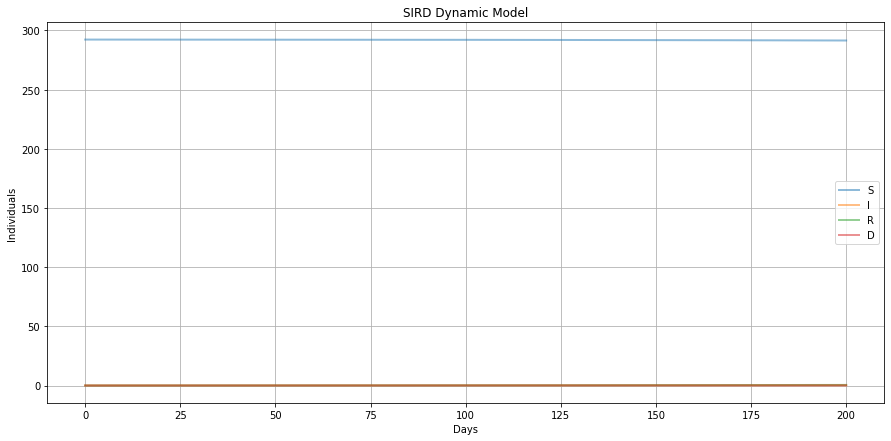

In [20]:
# Linear Model Simulation
System =  control.ss(Amatrix,Bmatrix,Cmatrix,Dmatrix)
T, yout = impulse_response(System, len(Date), X0= [Susceptible[0],Infected[0],Recovered[0],Deceased[0]],)


plt.figure(figsize=(15,7))
plt.plot(T,yout[0][0], alpha=0.5, lw=2, label='S') 
plt.plot(T,yout[1][0], alpha=0.5, lw=2, label='I')
plt.plot(T,yout[2][0], alpha=0.5, lw=2, label='R')
plt.plot(T,yout[3][0], alpha=0.5, lw=2, label='D')
plt.grid()
plt.legend()
plt.title('SIRD Dynamic Model')
plt.xlabel('Days')
plt.ylabel('Individuals')

plt.show()

# **Diagonal Form**


The state vector is not unique for a dynamic system $\Rightarrow$ there are many possibilities to define a state vector for the same dynamic system.

Each state vector will generate a different form of SS (State Space) for a same FT (Function Transfer).

There are some classic forms of state space representation.

## **Canonic Form**

Each form is useful for a particular purpose.

1.   Controllable;
2.   Observable;
3.   Jordan;
4.   Diagonal or Modal.

Most important way to analyze the dynamic systems $\Rightarrow $ diagonal or modal $\Rightarrow $ allows you to  easily visualize the system dynamics.

Matrix expressions in time can be written in the diagonal SS form, ie:

\begin{equation}
\begin{array}{l}
 \left[ {\begin{array}{l}
 \dot {x}_1 (t) \\ 
 \dot {x}_2 (t) \\ 
 \vdots \\ 
 \dot {x}_n (t) \\ 
 \end{array}} \right]=\left[ {{\begin{array}{*{20}c}
 {p_1 } \hfill & 0 \hfill & \cdots \hfill & 0 \hfill \\
 0 \hfill & {p_2 } \hfill & \cdots \hfill & 0 \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 0 \hfill & 0 \hfill & \cdots \hfill & {p_n } \hfill \\
\end{array} }} \right]\left[ {\begin{array}{l}
 x_1 (t) \\ 
 x_2 (t) \\ 
 \vdots \\ 
 x_n (t) \\ 
 \end{array}} \right]+\left[ {\begin{array}{l}
 r_1 \\ 
 r_2 \\ 
 \vdots \\ 
 r_n \\ 
 \end{array}} \right]u(t) \\ 
 y(t)=\left[ {{\begin{array}{*{20}c}
 1 \hfill & 1 \hfill & \cdots \hfill & 1 \hfill \\
\end{array} }} \right]\left[ {\begin{array}{l}
 x_1 (t) \\ 
 x_2 (t) \\ 
 \vdots \\ 
 x_n (t) \\ 
 \end{array}} \right] \\ 
 \end{array}
\end{equation}

Note that the A matrix is diagonal and its diagonal is the poles of the system.


In [ ]:
# Analyze of the Poles and Zeros of the system

control.pole(System)
control.zero(System)
control.damp(System)

_____Eigenvalue______ Damping___ Frequency_
         0                     1         -0
         0                     1         -0
 9.106e-31                     1 -9.106e-31
     19.11                     1     -19.11


/usr/local/lib/python3.7/dist-packages/control/lti.py:148: RuntimeWarning:

invalid value encountered in true_divide



(array([0.00000000e+00, 0.00000000e+00, 9.10632350e-31, 1.91102575e+01]),
 array([nan, nan, -1., -1.]),
 array([0.00000000e+00, 0.00000000e+00, 9.10632350e-31, 1.91102575e+01]))

# **Linear Transformation**

Given a LIT system in the form of state space:
 
 \begin{equation}
\left\{ {\begin{array}{l}
 {\rm {\bf \dot {x}}}(t)={\rm {\bf Ax}}(t)+{\rm {\bf Bu}}(t) \\ 
 {\rm {\bf y}}(t)={\rm {\bf Cx}}(t)+{\rm {\bf Du}}(t) \\ 
 \end{array}} \right.
\end{equation}

**What is the corresponding Transfer Function ?**


Aplicando a Transformada de Laplace na equação da dinâmica dos 
estados,
Applying the Laplace Transform to the equation of the dynamics of State,
\begin{equation}
L\left\{ {{\rm {\bf \dot {x}}}(t)} \right\}=L\left\{ {{\rm {\bf Ax}}(t)+{\rm 
{\bf Bu}}(t)} \right\}
\end{equation}
Assuming the Heavyside initial conditions (by definition the TF has initial condition equal to zero), we have:
\begin{equation}
s{\rm {\bf X}}(s)={\rm {\bf AX}}(s)+{\rm {\bf BU}}(s)
\end{equation}

Rearranging,
\begin{equation}
\left( {s{\rm {\bf I}}-{\rm {\bf A}}} \right){\rm {\bf X}}(s)={\rm {\bf 
BU}}(s)
\end{equation}
Isolating $\textbf{X}(s)$
\begin{equation}
{\rm {\bf X}}(s)=\left( {s{\rm {\bf I}}-{\rm {\bf A}}} \right)^{-1}{\rm {\bf 
BU}}(s)
\end{equation}

Applying the Laplace Transform to the equation of system outputs,
\begin{equation}
L\left\{ {{\rm {\bf y}}(t)} \right\}=L\left\{ {{\rm {\bf Cx}}(t)+{\rm {\bf 
Du}}(t)} \right\}
\end{equation}
or
\begin{equation}
{\rm {\bf Y}}(s)={\rm {\bf CX}}(S)+{\rm {\bf DU}}(s)
\end{equation}


Substituting the equations, we have:
\begin{equation}
{\rm {\bf Y}}(s)={\rm {\bf C}}\left( {s{\rm {\bf I}}-{\rm {\bf A}}} 
\right)^{-1}{\rm {\bf BU}}(s)+{\rm {\bf DU}}(s)
\end{equation}
\begin{equation}
{\rm {\bf Y}}(s)=\left[ {{\rm {\bf C}}\left( {s{\rm {\bf I}}-{\rm {\bf A}}} 
\right)^{-1}{\rm {\bf B}}+{\rm {\bf D}}} \right]{\rm {\bf U}}(s)
\end{equation}


Remember that the TF is the relation between the system's output and input, that is, $\textbf{Y}($s$)/\textbf{U}($s$)$,
\begin{equation}
{\rm {\bf G}}(s)={\rm {\bf C}}\left( {s{\rm {\bf I}}-{\rm {\bf A}}} 
\right)^{-1}{\rm {\bf B}}+{\rm {\bf D}}
\end{equation}

$\textbf{G}(s)$ is a matrix of Transfer Functions with dimensions $p \;x \; m$ ($p$ = number of outputs and $m$ = number of inputs);

Each element $G_{ij}(s)$ of the matrix $\textbf{G}(s)$ describes the dynamic of the output $i$ as a function of the input $j$ of the system $\Rightarrow $ for example, $G_{12}(s)$ describes the dynamic relationship between output 1 and input 2 of the system;

If the system only has one input and one output $\Rightarrow G(s)$ is a scalar.


There is a simple method to calculate the TF for systems of any order that does not require matrix inverse calculation, only matrices determinants:

\begin{equation}
G_{ij} (s)=\frac{\det \left[ {{\begin{array}{*{20}c}
 {s{\rm {\bf I}}-{\rm {\bf A}}} \hfill & {-{\rm {\bf B}}_{\rm {\bf j}} } 
\hfill \\
 {{\rm {\bf C}}_{\rm {\bf i}} } \hfill & {{\rm {\bf D}}_{{\rm {\bf ij}}} } 
\hfill \\
\end{array} }} \right]}{\det \left[ {s{\rm {\bf I}}-{\rm {\bf A}}} \right]}
\end{equation}
where $\textbf{C}_{i}$is the $i$-th row of the matrix $\textbf{C}$ and 
$\textbf{B}_{j}$ is the $j$-th column of the matrix $\textbf{B}$ and $\textbf{ 
D}_{ij}$ is the $i,j$ element of the matrix $\textbf{D}$. 

Note that, if the system is SISO $\Rightarrow  \textbf{C} $ is a row matrix and $\textbf{B}$ is a column matrix.

$\textbf{The denominators of all elements of the TF matrix, G(s)}$, are equal $\Rightarrow $ characteristic equation of the system.

The algebric calculation of a matrix inverse is not always a simple process to perform. The only case where we calculate the matrix is

\begin{equation}
{\rm {\bf A}}=\left[ {{\begin{array}{*{20}c}
 {a_{11} } \hfill & {a_{12} } \hfill \\
 {a_{21} } \hfill & {a_{22} } \hfill \\
\end{array} }} \right]
\end{equation}

\begin{equation}
\left( {s{\rm {\bf I}}-{\rm {\bf A}}} \right)^{-1}=\left[ 
{{\begin{array}{*{20}c}
 {s-a_{11} } \hfill & {-a_{12} } \hfill \\
 {-a_{21} } \hfill & {s-a_{22} } \hfill \\
\end{array} }} \right]^{-1}=\frac{1}{det} \left[ {{\begin{array}{*{20}c}
 {s-a_{22} } \hfill & {a_{12} } \hfill \\
 {a_{21} } \hfill & {s-a_{11} } \hfill \\
\end{array} }} \right]
\end{equation}

**For systems of order greater than two, we can use the Cramer's method $\Rightarrow $ very laborious.**

The determinant of a matrix of dimension $n$x$n$ is calculated by summing the cofactors of the matrix:

\begin{equation}
\det \left[ {{\begin{array}{*{20}c}
 {a_{11} } \hfill & {a_{12} } \hfill & \cdots \hfill & {a_{1n} } \hfill \\
 {a_{21} } \hfill & {a_{22} } \hfill & \cdots \hfill & {a_{2n} } \hfill \\
 \vdots \hfill & \vdots \hfill & \ddots \hfill & \vdots \hfill \\
 {a_{n1} } \hfill & {a_{n2} } \hfill & \cdots \hfill & {a_{nn} } \hfill \\
\end{array} }} \right]_{(nxn)} =a_{11} A_{11} +a_{12} A_{12} +\cdots +a_{1n} 
A_{1n} 
\end{equation}

where $A_{ij}$ is the cofactor of the element $a_{ij}$, given by:

\begin{equation}
A_{ij} =(-1)^{i+j}\det {\rm {\bf D}}_{{\rm {\bf ij}}} 
\end{equation}

# **Observability and Controllability**

A LIT system is contrallable if there is an input vector $\textbf{u}(t)$ for 0 $\le t \le T$, with $T  >$ 0 and finite, such that the system goes from initial condition $\textbf{x}(0)$ to any state 
$\textbf{x}$ in the time interval $T$.

Starting at $t$ = 0 is not a special case. If it can go to any state in finite time, starting at $ t$ = 0, then it can from any initial condition reach any state in finite time.

For controllability, just consider the forced solution of the system, ie:

\begin{equation}
{\rm {\bf x}}(t)=\int\limits_0^t {e^{{\rm {\bf A}}(t-\tau )}{\rm {\bf 
Bu}}(\tau )d\tau } .
\end{equation}


The controllability is associated to the ability to influence all states through the system's inputs.


Considering a $n$ order system, we have:
\begin{equation}
{\rm {\bf \dot {x}}}(t)={\rm {\bf Ax}}(t)+{\rm {\bf Bu}}(t),
\end{equation}
where $\textbf{x}(t)  \in  R^{n}$ and $\textbf{u}(t) \in   R^{m}$. 

Observe that for a system to be controllable, it is enough to analyze the equation of the states, that is, the pair of matrices $\textbf{A}$ and $\textbf{B}$.

Definition of a controllable matrix $\textbf{M}_{C}$:
\begin{equation}
{\rm {\bf M}}_{\rm {\bf C}} =\left[ {{\begin{array}{*{20}c}
 {\rm {\bf B}} \hfill & {{\rm {\bf AB}}} \hfill & {{\rm {\bf A}}^2{\rm {\bf 
B}}} \hfill & \cdots \hfill & {{\rm {\bf A}}^{n-1}{\rm {\bf B}}} \hfill \\
\end{array} }} \right].
\end{equation}

The system defined by the matrices ($\textbf{A}, \textbf{B}$) is controllable if rank($\textbf{M}_{C})=n$. $\textit{Rank}$ is equal to the rank of a matrix, represented by the number of rows and columns linearly independant in the matrix.


## **Observability**

A LIT system is observable if any initial condition $\textbf{x}(0)$ can be obtained by knowing the inputs $\textbf{u}(t)$ and the outputs $\textbf{y}(t)$ of the system for every instant of time $t$ between 0 and $T>0$.

If the initial condition of states $\textbf{x}(0)$ can be calculated, then the states vector $\textbf{x}(t)$ can be reconstructed at any instant of time. Note that if you know the initial condition $\textbf{x}(0)$ and the input vector $\textbf{u}(t)$ at any instant, then you can calculate $\textbf{x}(t)$ at any instant of time $t$.

To study the observability, it is enough to consider the case $\bf{u}(t)=0$, that is, the homogeneous solution, given by:

\begin{equation}
{\rm {\bf y}}(t)={\rm {\bf C}}e^{{\rm {\bf A}}t}{\rm {\bf x}}(0).
\end{equation}

**The observability is associated with the ability to "see" all states though system's outputs.**


Considering a $n$ order system, with an input vector $\textbf{u}(t)$=0, then you have:

\begin{equation}
\left\{ {\begin{array}{l}
 {\rm {\bf \dot {x}}}(t)={\rm {\bf Ax}}(t); \\ 
 {\rm {\bf y}}(t)={\rm {\bf Cx}}(t); \\ 
 \end{array}} \right.,
\end{equation}

where $\textbf{x}(t) \in R^{n}$ and $\textbf{y}(t) \in  R^{p}$. \\
Note that for a system to be observable it is enough to analyze the pair of matrices $\textbf{A}$ and $\textbf{C}$.

Definition of an observability matrix $\textbf{M}_{O}$:

\begin{equation}
{\rm {\bf M}}_{\rm {\bf O}} =\left[ {\begin{array}{l}
 {\rm {\bf C}} \\ 
 {\rm {\bf CA}} \\ 
 {\rm {\bf CA}}^2 \\ 
 \vdots \\ 
 {\rm {\bf CA}}^{n-1} \\ 
 \end{array}} \right].
\end{equation}

The system defined by the matrices ($\textbf{A}, \textbf{C}$) is observable if $ rank(\textbf{M}_{O})=n$.

In [21]:
Observability = control.obsv(Amatrix, Cmatrix)
npl.matrix_rank(Observability)

4

In [22]:
Controlability = control.ctrb(Amatrix, Bmatrix)
npl.matrix_rank(Controlability)

0

In [23]:
# Analyze of the system poles and zeros
control.pole(System)
control.zero(System)
control.damp(System)

_____Eigenvalue______ Damping___ Frequency_
         0                     1         -0
         0                     1         -0
         0                     1         -0
  0.009732                     1  -0.009732


/usr/local/lib/python3.7/dist-packages/control/lti.py:148: RuntimeWarning:

invalid value encountered in true_divide



(array([0.        , 0.        , 0.        , 0.00973167]),
 array([nan, nan, nan, -1.]),
 array([0.        , 0.        , 0.        , 0.00973167]))

In [24]:
state_space.A, state_space.B

(array([[ 0.        , -0.04219775,  0.        ,  0.        ],
        [ 0.        ,  0.00973167,  0.        ,  0.        ],
        [ 0.        ,  0.02597297,  0.        ,  0.        ],
        [ 0.        ,  0.00649311,  0.        ,  0.        ]]), array([[0.],
        [0.],
        [0.],
        [0.]]))

In [25]:
matrix_rank(Bmatrix)

0

In [26]:
# Control Project

# Amf = A - BK _ A is known and B is known - model
# Amf is also know --> gain K
Amatrix, Bmatrix, Cmatrix, Dmatrix = state_space.A, state_space.B, state_space.C, state_space.D

# Control Project
K = control.place(Amatrix, Bmatrix, [-.5, -.25, 0, -3]) # LQR - quadratic linear regulator
C = np.array([[0, 1]]) # Regulated output --> C = [[1, 0][0 1]] two outputs
kf = -1/(C @ np.linalg.inv(Amatrix - Bmatrix @ K) @ B)

ValueError: ignored

In [ ]:
K ### multiplication - gain 0.08918657*preys + 0.0865658* predators - control law

In [ ]:
kf ### "normalize" the output/input ratio

In [ ]:
K = K1a

In [ ]:
###################################################################################################
# Creating a controller - control.y[0] - block of control

io_controller = control.NonlinearIOSystem(
  None,
  lambda t, x, u, params: -K @ (u[1:] - xe) + kf * (u[0] - xe[1]),
  inputs=('Ld', 'u1', 'u2'), outputs=1, name='control')

In [ ]:
###################################################################################################
# Closing the control loop

# Connecting the code blocks

io_closedloop = control.InterconnectedSystem(
  (io_preypredador, io_controller),       # systems
  connections=(
    ('preypreda.u', 'control.y[0]'),
    ('control.u1',  'preypreda.H'),
    ('control.u2',  'preypreda.L')
  ),
  inplist=('control.Ld'),
  outlist=('preypreda.H', 'preypreda.L', 'control.y[0]')
)

In [ ]:
###################################################################################################
# Simulation of the system

t, y = control.input_output_response(io_closedloop, T, 30, [15, 20])

# Visualization of the results

plt.figure(figsize=(15,7))
plt.subplot(2, 1, 1)
plt.plot(t, y[0])
plt.plot(t, y[1])
plt.legend(['Prey', 'Predador'])
plt.subplot(2, 1, 2)
plt.plot(t, y[2])
plt.legend(['Input'])
plt.show(block=False)

\begin{equation}
\left[
  u_1 \quad  u_2 \right]*
\left[
  \begin{array}{l}
  u_1 \\
  u_2
  \end{array} \right]
  = u_1^2 + u_2^2
\end{equation}

\begin{equation}
J = \int_0^{t_f} x(t)^TQ_{x1}x(t) + u(t)^TQ_{u1a}u(t) dt
\end{equation}

In [ ]:
Qx1 = np.diag([0.01, 0.01])
Qu1a = np.diag([1])
K, X, E = control.lqr(A, B, Qx1, Qu1a)
K1a = np.matrix(K)

# **Project with a state observer**

## **Block diagram examples**

In [ ]:
P = control.tf2io(control.tf(1, [1, 0]), inputs='u', outputs='y')
C = control.tf2io(control.tf(10, [1, 1]), inputs='e', outputs='u')
sumblk = control.summing_junction(inputs=['r', '-y'], output='e')
T = control.interconnect([P, C, sumblk], inplist='r', outlist='y')

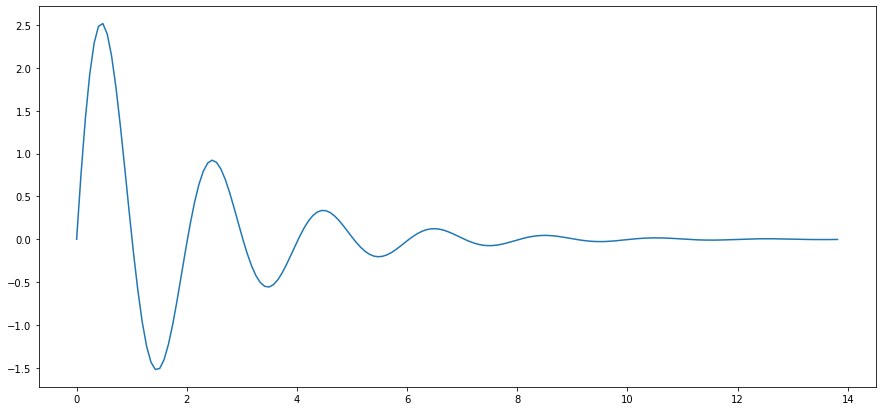

In [ ]:
# Simulation
# Syntax : t, y = input_output_response(io_sys, T, U, X0, params)

t, output = control.impulse_response(T)

plt.figure(figsize=(15,7))
plt.plot(t,output) # Linx
plt.show()

# **Tuning the coefficients**

In [28]:
# Modification of the model - generalization

def dynamicmodel2(t, x, u, parameters):
  """ Creation of the non linear model phenomenon
    t: timeline
    x: initial state vector
    u: input
    parameters: model's parameters """

  # Initial Parameters
  beta = parameters.get('beta')
  gamma = parameters.get('gamma')
  mu = parameters.get('mu')
  u_0 = 0

  # Initial Values of SIRD - x_o =[xo1 xo2].T
  S = x[0];
  I = x[1];
  R = x[2];
  D = x[3];

  # System's entry - Add content in the system - Never remove
  u = u_0 if u > 0 else 0 

  # Formalize equations
  dS = -beta*I*S
  dI = beta*I*S -gamma*I -mu*I
  dR = gamma*I
  dD = mu*I

  return [dS,dI,dR,dD]

In [29]:
# Creating the corresponding sub system
# Syntax: io_sys = NonlinearIOSystem(updfcn, outfcn, inputs=M, outputs=P, states=N)

io_model = control.NonlinearIOSystem(
    dynamicmodel2, None, inputs=('u'), outputs=('S', 'I', 'R', 'D'),
    states=('S', 'I', 'R', 'D'), params={'beta':0.13099162,'gamma':0.03978684,'mu':0.00244559}, name='SIRD_model')

In [30]:
#  Determination of the equilibrium point

x0 = [Susceptible[0],Infected[0],Recovered[0],Deceased[0]]
equilibrium = control.find_eqpt(io_model,x0,0)
equilibrium

(array([ 1.46211566e+02, -6.95183673e-30, -4.56702770e+02, -5.58519759e+01]),
 array([0.]))

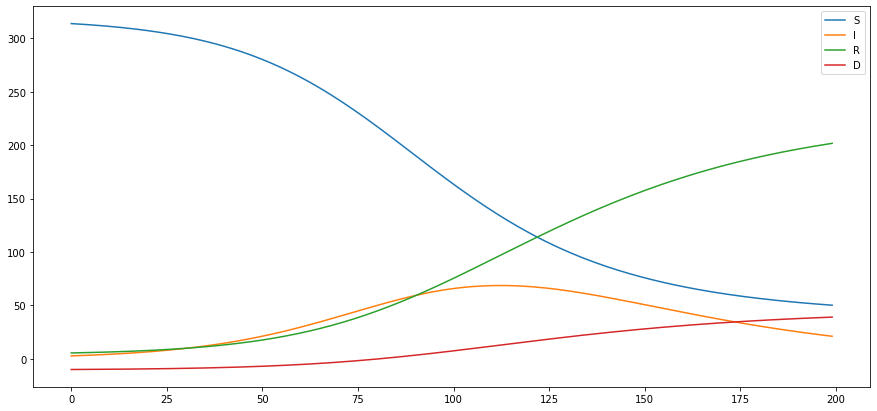

In [31]:
# Simulation
#x0 = [ 1.46211566e+02, 2, 4.56702770e+02, 5.58519759e+01] #equilibrium
#x0 = [ 7.46211566e+02, 3, 4.56702770, 5.58519759e+01] #iterative test
x0 = [3.13691306e+02, 2.76203192e+00, 5.51029952e+00, -9.97377960e+00] #Tuned parameters

# Calculation in time

#parameters = {'beta':0.13099162,'gamma':0.03978684,'mu':0.00244559} #from SIRDsim
parameters = {'beta':2.42477206e-04,'gamma':2.59729704e-02,'mu':6.49310855e-03} #Tuned parameters

# Syntax : t, y = input_output_response(io_sys, T, U, X0, params)

t, output = control.input_output_response(io_model, np.linspace(0,len(Date)-1,len(Date)), 0, x0, parameters)

plt.figure(figsize=(15,7))
plt.plot(t,output[0],label='S') # S
plt.plot(t,output[1],label='I') # I
plt.plot(t,output[2],label='R') # R
plt.plot(t,output[3],label='D') # D
plt.legend()
plt.show()

To estimate model parameters, we will initially use the least squares method. Then we can formulate the problem from the equation below. In the equation, $y_m(k)$ represents the real data in each sample $k$; $y_s(\theta,k)$ represents the **estimated value** from the model simulation for a given sample $k$ and $\theta$ represents the parameters vector $\theta = [ \beta \; \; \gamma \; \; \mu \; \; x(0) \; \; x(1) \; \; x(2)\; \; x(3)]^T$.

$$ min_{\theta}= \sum_{k=1}^{K}(y_m(k) - y_s(\theta,k))^2 $$

The equation asks the question: Which values of  $\beta \; \; \gamma \; \; \mu \; \; x(0) \; \; x(1) \; \; x(2)\; \; x(3) $ minimize the squared error when compared to the real data.

In [32]:
Sn = np.array(Susceptible)
In = np.array(Infected)
Rn = np.array(Recovered)
Dn = np.array(Deceased)
tn = np.linspace(0,len(Date)-1,len(Date))

In [33]:
len(tn)

200

In [34]:
# Determine the merit function
def ErroQuadratico(Sn,In,Rn,Dn,tn,x0,u,parameters):
    """ function to pass to scipy.optimize.fmin
        The routine will square and sum the values returned by 
        this function""" 
    t, y = control.input_output_response(io_model, tn, u, x0, parameters)
    erroS = y[0] - Sn
    erroI = y[1] - In
    erroR = y[2] - Rn
    erroD = y[3] - Dn
    EQ = np.sum((np.concatenate([erroS,erroI,erroR,erroD])**2))
    return EQ

def objetivo(p):
  parameters = {'beta':p[0],'gamma':p[1],'mu':p[2]}
  xi = [p[3],p[4],p[5],p[6]]
  return ErroQuadratico(Sn,In,Rn,Dn,tn,xi,0,parameters)

In [35]:
import scipy.optimize

xopt = scipy.optimize.fmin(func=objetivo, x0=[0.13099162 , 0.03978684, 0.00244559,7.46211566e+02, 3, 4.56702770, 5.58519759e+01])

In [36]:
xopt

array([ 2.42477206e-04,  2.59729704e-02,  6.49310855e-03,  3.13691306e+02,
        2.76203192e+00,  5.51029952e+00, -9.97377960e+00])

# **Conclusion**

Establishing this Notebook, many struggles were encountered.
Indeed, during weeks I only had computational errors, not being able to observe any results. To solve those issues, I had to study every part of the model to find them first, and then try some new alternatives.
Among the issues there was:
1. *$\color{red}{Windowing:}$* the dynamic model could not fit because I used the whole dataset first, so the data was composed of several Covid waves, showing an uncommon behaviour. \\
 *$\color{green}{Solution:}$* **windowing** of the study to only one bunch of data, only showing one wave. \\
1. *$\color{red}{Overflow:}$* due to the high amount of individuals, the model has difficulties to fit (it just could not end computation), with a lot of uncomprehensive errors. \\
 *$\color{green}{Solution:}$* **normalize** data by dividing by 100.
1. *$\color{red}{Initial \ parameters \ \beta \ \gamma \ \mu:}$* to start the model fitting, a bunch of initial parameters need to be given. However, giving some random ones could be an obstacle to the fitting. \\
 *$\color{green}{Solution:}$*
 - First attempt was to find the right parameters for the specific study case with our **previous SIRD model**. Afterwards, it was a good start to fit them and find the perfect ones.
 - Finally, the best method is to come along and find the best parameters by fitting the **dynamic model**, but it requires to be able to compute right.
1. *$\color{red}{Initial \ State \ Values:}$* as the previous point, initial state values need to be given to start the fitting, to get some (relevant) results. \\
 *$\color{green}{Solution:}$*
 - First attempt was to find the **equilibrium values** for the system with the control library, and then inject them into the model: not relevant, it even occurs with ghost errors, not knowing where it comes from.
 - Second attempt was to iterate and **try manually some values**. For example taking close values to the real data initial values: not relevant either.
 - Last attempt was to **tune parameters** with the least square method: best method. 
